In [1]:
from collections import OrderedDict
import numpy as np
import cv2
import argparse
import dlib
import imutils
import matplotlib.pyplot as plt
%matplotlib inline
import math
import pandas as pd
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

face_cascade = cv2.CascadeClassifier('haarcascade_frontface.xml')
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [2]:
#facial keypoint 추출
#출처: https://github.com/HooSeungNa/pytorch/tree/master/emotion_recognition/face_detector

facial_features_cordinates = {}

FACIAL_LANDMARKS_INDEXES = OrderedDict([
    ("Mouth", (49, 68)),
    ("Right_Eyebrow", (17, 21)),
    ("Left_Eyebrow", (22, 26)),
    ("Right_Eye", (36, 41)),
    ("Left_Eye", (42, 47)),
    ("Nose", (27, 35)),
    ("Jaw", (0, 16))
])

def shape_to_numpy_array(shape, dtype="int"): 

    coordinates = np.zeros((68, 2), dtype=dtype)

    for i in range(0, 68):
        coordinates[i] = (shape.part(i).x, shape.part(i).y)

    return coordinates

#landmark 이어주기
def visualize_facial_landmarks_contour(image, shape, colors=None, alpha=0.75):
    
    overlay = image.copy()
    output = image.copy()

    
    if colors is None:
        colors = [(19, 199, 109), (79, 76, 240), (230, 159, 23),
                  (168, 100, 168), (158, 163, 32),
                  (163, 38, 32), (180, 42, 220)]

    for (i, name) in enumerate(FACIAL_LANDMARKS_INDEXES.keys()):
        print(i,name)


        (j, k) = FACIAL_LANDMARKS_INDEXES[name]
        pts = shape[j:k]
        facial_features_cordinates[name] = pts

        if name == "Jaw":        

            for l in range(1, len(pts)):
                ptA = tuple(pts[l - 1])
                ptB = tuple(pts[l])
                cv2.line(overlay, ptA, ptB, colors[i], 2)

        else:
            hull = cv2.convexHull(pts)
            cv2.drawContours(overlay, [hull], -1, colors[i], -1)

    cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)

    return output

def visualize_facial_landmarks_circle(image, shape, colors=None, alpha=0.75):
    
    for i in range(len(shape)):
        po=shape[i]
        center=(int(po[0]),int(po[1]))
        cv2.circle(image,center,2,(0,255,0),thickness=3)
        plt.imshow(image)

    return image

In [3]:
######################### 1. Face Variance Extraction Using Random Forest #########################

In [4]:
#변수 설정을 위한 함수
def angle_between(p1, p2):
        ang1 = np.arctan2(*p1[::-1])
        ang2 = np.arctan2(*p2[::-1])
        res = np.rad2deg((ang1 - ang2) % (2 * np.pi))
        return res

def getAngle3(p1, p2, p3):
        pt1 = (p1[0] - p2[0], p1[1] - p2[1])
        pt2 = (p3[0] - p2[0], p3[1] - p2[1])
        res = angle_between(pt1, pt2)
        res = (res + 360) % 360
        if res>180:
            res = (360 - res) % 360
        return res
    
def getAngle4(p1, p2, p3, p4):
        pt1 = (p1[0] - p2[0], p1[1] - p2[1])            
        pt2 = (p3[0] - p4[0], p3[1] - p4[1])        
        res = angle_between(pt1, pt2)
        res = (res + 360) % 360
        if res>180:
            res = (360 - res) % 360
        return res
    
def dist(a, b):
    A = np.array(shape[a])
    B = np.array(shape[b])
    len = np.linalg.norm(A-B)
    return len

In [5]:
#얼굴 변수 설정
def var(a):
    global count2, array
    
    x = np.array(shape[8])
    mid = (int(shape[0][0] + shape[16][0])/2, int(shape[0][1] + shape[16][1])/2)

    array[a+1][0]= getAngle3(shape[0], shape[8], shape[16])
    array[a+1][1]= getAngle3(shape[7], shape[8], shape[9])
    array[a+1][2]= dist(7, 9) / dist(0, 16)
    array[a+1][3]= dist(6, 10) / dist(0, 16)
    array[a+1][4]= dist(0, 16) / np.linalg.norm(x-mid)
    array[a+1][5]= getAngle3(shape[0], shape[4], shape[8])
    array[a+1][6]= getAngle3(shape[8], shape[12], shape[16])
    array[a+1][7]= getAngle3(shape[39], shape[8], shape[42])
    array[a+1][8]= dist(36, 39) / dist(37, 40)
    array[a+1][9]= dist(36, 39) / dist(38, 41)
    array[a+1][10]= dist(36, 39) / dist(0, 16)
    array[a+1][11]= dist(36, 39) / np.linalg.norm(x-mid)
    array[a+1][12]= getAngle4(shape[0], shape[16], shape[36], shape[39])
    array[a+1][13]= getAngle4(shape[36], shape[37], shape[38], shape[39])
    array[a+1][14]= getAngle4(shape[36], shape[41], shape[40], shape[39])
    array[a+1][15]= dist(42, 45) / dist(43, 46)
    array[a+1][16]= dist(42, 45) / dist(44, 47)
    array[a+1][17]= dist(42, 45) / dist(0, 16)
    array[a+1][18]= dist(42, 45) / np.linalg.norm(x-mid)
    array[a+1][19]= getAngle4(shape[0], shape[16], shape[42], shape[45])
    array[a+1][20]= getAngle4(shape[42], shape[43], shape[44], shape[45])
    array[a+1][21]= getAngle4(shape[42], shape[47], shape[46], shape[45])
    array[a+1][22]= dist(36, 39) / dist(39, 42)
    array[a+1][23]= dist(39, 42) / dist(0, 16)
    array[a+1][24]= getAngle3(shape[31], shape[33], shape[35])
    array[a+1][25]= dist(27, 33) / dist(31, 35)
    array[a+1][26]= dist(27, 33) / dist(0, 16)
    array[a+1][27]= dist(27, 30) / dist(0, 16)
    array[a+1][28]= dist(27, 33) / np.linalg.norm(x-mid)
    array[a+1][29]= dist(27, 30) / np.linalg.norm(x-mid)
    array[a+1][30]= getAngle3(shape[31], shape[27], shape[35])
    array[a+1][31]= dist(31, 35) / dist(0, 16)
    array[a+1][32]= count2

    return array

In [6]:
#Face Data 변수값 csv 파일로 저장
i=0
array = [[0 for col in range(33)] for row in range(501)]
count2 = 0

for j in range(500):
    
    count = i % 20
    if i % 20 == 0 and i!= 0:
        count2 += 1
    name = str(i)+'.jpg'
    os.chdir('C:/Users/user/Machine_Learning/Face_Data')
    image = cv2.imread(name)
    image = imutils.resize(image, width=500)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x,y,w,h) in faces:
        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)

    rect=dlib.rectangle(int(x), int(y), int(x + w), int(y + h))

    shape = predictor(gray, rect)
    shape = shape_to_numpy_array(shape)
    
    var(i)
    
    i += 1
    
for i in range(32):
    array[0][i]= i
    
array[0][32] = 100

os.chdir('C:/Users/user/Machine_Learning/Face_Data')
dataframe = pd.DataFrame(array)
dataframe.to_csv('Face_Var.csv', header=False, index=False)

In [7]:
#Change Index Name on the CSV File

In [8]:
os.chdir('C:/Users/user/Machine_Learning/Face_Data')
data = pd.read_csv('Face_Var.csv')
data.head()

,VAR0,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7,VAR8,VAR9,...,VAR23,VAR24,VAR25,VAR26,VAR27,VAR28,VAR29,VAR30,VAR31,TARGET
0,60.834060,155.132105,0.242808,0.457056,1.174371,143.126789,139.471480,17.630382,2.176627,1.942945,...,0.267797,144.323592,1.881391,0.396369,0.278507,0.465484,0.327071,32.406331,0.210679,0
1,60.834060,155.132105,0.242808,0.457056,1.174371,143.126789,139.471480,17.630382,2.176627,1.942945,...,0.267797,144.323592,1.881391,0.396369,0.278507,0.465484,0.327071,32.406331,0.210679,0
2,62.952045,159.554545,0.253389,0.468139,1.224885,141.287047,138.344542,17.432984,2.080311,1.971131,...,0.256979,149.730321,1.829536,0.380062,0.260402,0.465533,0.318963,32.881821,0.207737,0
3,62.952045,159.554545,0.253389,0.468139,1.224885,141.287047,138.344542,17.432984,2.080311,1.971131,...,0.256979,149.730321,1.829536,0.380062,0.260402,0.465533,0.318963,32.881821,0.207737,0
4,65.553289,165.646741,0.266890,0.494151,1.288243,132.375375,132.413771,17.667165,2.112829,1.976509,...,0.257376,151.137277,1.858022,0.393820,0.260686,0.507336,0.335826,32.248339,0.211957,0


In [9]:
#check the size
nCar = data.shape[0]
nVar = data.shape[1]
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 500 nVar: 33


In [10]:
after_mapping_target = data['TARGET']

feature_columns = list(data.columns.difference(['TARGET']))
X = data[feature_columns]
y = after_mapping_target

#train, test data 비율을 8:2 로 분할
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 42) 
#데이터 개수 확인
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape) 

(400, 32) (100, 32) (400,) (100,)


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(n_estimators=500, max_depth=20,random_state=0)
clf.fit(train_x,train_y)

RandomForestClassifier(max_depth=20, n_estimators=500, random_state=0)

In [12]:
#정확도 계산
predict1 = clf.predict(test_x)
print(accuracy_score(test_y, predict1))

0.99


In [13]:
#변수 중요도 출력
print(clf.feature_importances_)

[0.04423093 0.01250363 0.02653452 0.03076703 0.02389404 0.01622736
 0.01923674 0.01081588 0.01724493 0.02580978 0.02478877 0.03778105
 0.027828   0.01444879 0.02586483 0.03200951 0.05500428 0.03843678
 0.05241626 0.04389458 0.03904031 0.02861204 0.03124786 0.03799509
 0.05148176 0.05290051 0.04978909 0.02370698 0.02421307 0.05001582
 0.01448605 0.01677371]


In [14]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': clf.feature_importances_
})

feature_importance

,feature,importance
0,VAR0,0.044231
1,VAR1,0.012504
2,VAR10,0.026535
3,VAR11,0.030767
4,VAR12,0.023894
5,VAR13,0.016227
6,VAR14,0.019237
7,VAR15,0.010816
8,VAR16,0.017245
9,VAR17,0.025810


In [15]:
feature_importance.sort_values('importance', inplace=True)
feature_importance.reset_index(drop=True, inplace=True)

In [16]:
import plotly.express as px

fig = px.bar(feature_importance, x='feature', y='importance')
fig.show()

In [17]:
######################### 2. Face Aging Correction Using Polynomial Regression #########################

In [18]:
#Celeb Data 변수값 csv 파일로 저장
i=0
array = [[0 for col in range(33)] for row in range(101)]
count2 = 0

for j in range(100):
    
    count = i % 2
    if i % 2 == 0 and i!= 0:
        count2 += 1
    name = str(i)+'.jpg'
    os.chdir('C:/Users/user/Machine_Learning/Celeb')
    image = cv2.imread(name)
    image = imutils.resize(image, width=500)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x,y,w,h) in faces:
        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)

    rect=dlib.rectangle(int(x), int(y), int(x + w), int(y + h))

    shape = predictor(gray, rect)
    shape = shape_to_numpy_array(shape)
    
    var(i)
    
    i += 1
    
for i in range(32):
    array[0][i]= i
    
array[0][32] = 100

os.chdir('C:/Users/user/Machine_Learning/Celeb')
dataframe = pd.DataFrame(array)
dataframe.to_csv('Celeb_VAR.csv', header=False, index=False)

In [19]:
#transform csv file
os.chdir('C:/Users/user/Machine_Learning/Celeb')
data = pd.read_csv("Celeb_VAR.csv")
Ydata = data.loc[[0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50,52,54,56,58,60,62,64,66,68,70,72,74,76,78,80,82,84,86,88,90,92,94,96,98],:]
Ydata = Ydata.values.tolist()
Ydata = pd.DataFrame(Ydata, columns = ['y0','y1','y2','y3','y4','y5','y6','y7','y8','y9','y10','y11','y12','y13','y14','y15','y16','y17','y18','y19','y20','y21','y22','y23','y24','y25','y26','y27','y28','y29','y30','y31','T'])
Ydata = Ydata.drop(['T'], axis = 1)

Odata = data.loc[[1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53,55,57,59,61,63,65,67,69,71,73,75,77,79,81,83,85,87,89,91,93,95,97,99],:]
Odata = Odata.values.tolist()
Odata = pd.DataFrame(Odata, columns = ['o0','o1','o2','o3','o4','o5','o6','o7','o8','o9','o10','o11','o12','o13','o14','o15','o16','o17','o18','o19','o20','o21','o22','o23','o24','o25','o26','o27','o28','o29','o30','o31','T'])
Odata = Odata.drop(['T'], axis = 1)
data = pd.concat([Ydata, Odata], axis = 1)
data.to_csv('C:/Users/user/Machine_Learning/Celeb/Celeb_VAR.csv')

In [20]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)
print(train_set.shape, test_set.shape)

(40, 64) (10, 64)


<AxesSubplot:xlabel='o0', ylabel='y0'>

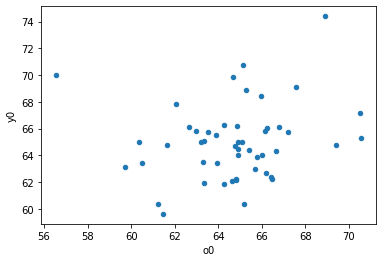

In [21]:
vx="o0"
vy="y0"

data.plot(kind="scatter", x=vx, y=vy)

In [22]:
data1 = train_set[[vx]].copy()
data1_labels = train_set[[vy]].copy()

test1 = test_set[[vx]].copy()
test1_labels = test_set[[vy]].copy()

In [23]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

i_d=3 #차수 
poly_features = PolynomialFeatures(degree=i_d, include_bias=False)
X_poly = poly_features.fit_transform(data1)
X_poly[0]

array([6.05139810e+01, 3.66194189e+03, 2.21598682e+05])

In [24]:
num = [0]*4 #계수

lin_reg = LinearRegression()
lin_reg.fit(X_poly, data1_labels)
lin_reg.intercept_, lin_reg.coef_

print(lin_reg.coef_)
num = [0]*4

num[0] = lin_reg.intercept_
num[1] = lin_reg.coef_[0][0]
num[2] = lin_reg.coef_[0][1]
num[3] = lin_reg.coef_[0][2]

[[-4.23643476e+01  6.26587506e-01 -3.05276411e-03]]


In [25]:
from sklearn.metrics import mean_squared_error

y_tr = lin_reg.predict(X_poly)
mean_squared_error(y_tr, data1_labels, squared = False)

2.7247658715759853

In [26]:
test1_poly = poly_features.fit_transform(test1)
y_p = lin_reg.predict(test1_poly)
mean_squared_error(y_p, test1_labels, squared = False)
print(vx)
print(mean_squared_error(y_p, test1_labels, squared = False))

o0
2.171602379994836


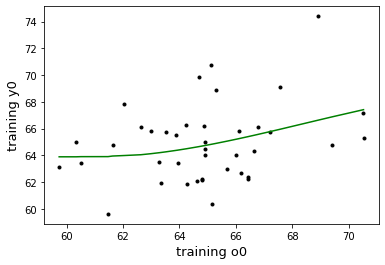

In [27]:
import pylab as pl
import matplotlib.font_manager as fm

p_y=lin_reg.predict(X_poly)
x=np.unique(data1)
y=np.unique(p_y)

pl.plot(data1, data1_labels, 'k.')

plt.xlabel("training o0", fontsize=13)                     
plt.ylabel("training y0", rotation=90, fontsize=13) 
pl.plot(x, y,'g')

In [28]:
#Aging Correction
def old2young(var, value):
    
    os.chdir('C:/Users/user/Machine_Learning/Celeb')
    data = pd.read_csv("Celeb_VAR.csv")

    train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

    vx = "o"+str(var)
    vy = "y"+str(var)

    data1 = train_set[[vx]].copy()
    data1_labels = train_set[[vy]].copy()

    test1 = test_set[[vx]].copy()
    test1_labels = test_set[[vy]].copy()

    i_d=3
    poly_features = PolynomialFeatures(degree=i_d, include_bias=False)
    X_poly = poly_features.fit_transform(data1)
    lin_reg = LinearRegression()
    lin_reg.fit(X_poly, data1_labels)
    
    num = [0]*4

    num[0] = lin_reg.intercept_
    num[1] = lin_reg.coef_[0][0]
    num[2] = lin_reg.coef_[0][1]
    num[3] = lin_reg.coef_[0][2]
    
    x = value
    p_y = num[3]*(x**3)+num[2]*(x**2)+num[1]*x+num[0]
    
    return p_y

In [29]:
######################### 3. Family Face Similarity #########################

In [30]:
#Family Face Data 변수값 csv 파일로 저장
i=0
array = [[0 for col in range(33)] for row in range(7)]
count2 = 0

for j in range(6):
    
    count = i % 1
    if i % 1 == 0 and i!= 0:
        count2 += 1
    name = str(i)+'.jpg'
    os.chdir('C:/Users/user/Machine_Learning/Family_Face_Data')
    image = cv2.imread(name)
    image = imutils.resize(image, width=500)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x,y,w,h) in faces:
        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)

    rect=dlib.rectangle(int(x), int(y), int(x + w), int(y + h))

    shape = predictor(gray, rect)
    shape = shape_to_numpy_array(shape)
    
    var(i)
    
    i += 1
    
for i in range(32):
    array[0][i]= i
    
array[0][32] = 100

os.chdir('C:/Users/user/Machine_Learning/Family_Face_Data')
dataframe = pd.DataFrame(array)
dataframe.to_csv('Family_Var.csv', header=False, index=False)

In [31]:
#Change Index Name on the CSV File

In [32]:
os.chdir('C:/Users/user/Machine_Learning/Family_Face_Data')
data = pd.read_csv("Family_Var.csv")
data

,VAR0,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7,VAR8,VAR9,...,VAR23,VAR24,VAR25,VAR26,VAR27,VAR28,VAR29,VAR30,VAR31,TARGET
0,66.203476,168.966210,0.278634,0.519064,1.304485,131.877051,133.951019,21.898193,2.334496,2.302173,...,0.293973,139.641869,1.749108,0.400755,0.312980,0.522779,0.408277,35.371441,0.229120,0
1,57.498578,157.163820,0.250148,0.458057,1.097214,137.103686,142.222813,18.163553,2.178658,2.033134,...,0.269213,147.402597,1.767951,0.442249,0.354013,0.485242,0.388428,34.262172,0.250148,1
2,68.925181,156.288849,0.209501,0.405932,1.372985,131.628738,134.707179,22.918683,1.910715,1.831910,...,0.292306,146.404480,2.047147,0.383976,0.287848,0.527193,0.395211,29.533179,0.187566,2
3,64.106125,159.687174,0.249993,0.462689,1.252317,136.234575,135.165054,19.719142,2.281019,2.092927,...,0.272380,142.386043,2.149041,0.376874,0.283574,0.471965,0.355125,28.361485,0.175368,3
4,66.290133,160.687504,0.251227,0.469285,1.306210,134.493611,133.692553,21.107286,2.047384,1.970596,...,0.284357,157.905770,1.853659,0.360186,0.251182,0.470478,0.328096,31.784316,0.194311,4
5,64.701516,165.912115,0.229164,0.433345,1.268024,138.025575,140.141037,24.912916,2.113909,2.033835,...,0.327281,150.484170,1.947069,0.390603,0.299297,0.495294,0.379515,30.788963,0.200611,5


In [34]:
for i in range(6):
    if i % 3 == 0 or i % 3 == 1:
        val = data.at[i, 'VAR0']
        data.at[i, 'VAR0'] = old2young(0, val)
        val = data.at[i, 'VAR7']
        data.at[i, 'VAR7'] = old2young(7, val)
        val = data.at[i, 'VAR23']
        data.at[i, 'VAR23'] = old2young(23, val)
        val = data.at[i, 'VAR25']
        data.at[i, 'VAR25'] = old2young(25, val)
        val = data.at[i, 'VAR26']
        data.at[i, 'VAR26'] = old2young(26, val)
        val = data.at[i, 'VAR30']
        data.at[i, 'VAR30'] = old2young(30, val)
        val = data.at[i, 'VAR31']
        data.at[i, 'VAR31'] = old2young(31, val)

In [35]:
#유사도 계산
arr_fm = data.to_numpy()

def sim(i): #i = VAR, 사람 세명 비교
    child = arr_fm[5][i]
    mom = arr_fm[4][i]
    dad = arr_fm[3][i]
    
    M = abs(mom - child)
    D = abs(dad - child)
    
    if min(M, D) == M:
        return print('아이는 VAR' + str(i) + '에 대해 엄마를 더 닮았습니다.')
    
    else:
        return print('아이는 VAR' + str(i) + '에 대해 아빠를 더 닮았습니다.')
    
def per(m,d):
    sum = m + d
    if m > d :
        per = (m / sum)*100
        return print('아이는 ' + str(per) + '%로 엄마를 더 닮았습니다.')
    
    elif m < d :
        per = (d / sum)*100
        return print('아이는 ' + str(per) + '%로 아빠를 더 닮았습니다.')
    
    else:
        return print('아이는 엄마 아빠를 반반씩 닮았습니다.') 

In [36]:
#ex. person2
sim(0)
sim(7)
sim(23)
sim(25)
sim(26)
sim(30)
sim(31)

아이는 VAR0에 대해 아빠를 더 닮았습니다.
아이는 VAR7에 대해 엄마를 더 닮았습니다.
아이는 VAR23에 대해 엄마를 더 닮았습니다.
아이는 VAR25에 대해 아빠를 더 닮았습니다.
아이는 VAR26에 대해 아빠를 더 닮았습니다.
아이는 VAR30에 대해 아빠를 더 닮았습니다.
아이는 VAR31에 대해 엄마를 더 닮았습니다.


In [37]:
per(3,4)

아이는 57.14285714285714%로 아빠를 더 닮았습니다.
